# Thinkful Data Science Unit 1 Capstone Project

For this capstone project I analyse the results of **A/B test run by eCommerce company**. <br>
***Goal:*** help company to decide should they apply new home page or keep the old version of webpage. <br>
***Success metric:*** Our success metric is conversions. <br>
***Secondary metric:*** I'll pick days of the week as a secondary success metric. I'll analyze if conversion rate in a specific day of the week is statistically significant or not.

# 1. Exploratory Data Analysis (EDA)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy import stats
import statsmodels.api as sm

In [2]:
# read the data
df = pd.read_csv(r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 1\Datas\eCommerce_AB_test\ab_test_data.csv')

# take a look at the data
print(df.shape)
df.head(10)

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


Our dataset has 294478 rows and 5 columns described below:
 - user_id: unique ID per webpage visitor
 - timestamp: date & time when user visited the webpage
 - group: control and treatment (test) groups
 - landing_page: what page the user visited. old_page or new_page. Obviously, the control group was redirected to the old page, while the treatment group was turned to the new page.
 - converted: is a binary indicator if the users were converted.

In [3]:
# number of times the groups and landing pages don't line up
print('number of unbalanced values: {}'.format(((df.group=='treatment') & (df.landing_page=='old_page')).sum() + 
      ((df.group == 'control') & (df.landing_page == 'new_page')).sum()))

# any missing values?
print('number of missing values: {}'.format(df.isnull().sum()))

number of unbalanced values: 3893
number of missing values: user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [4]:
# number of duplicate user ids
print('duplicate user ids: {}'.format(len(df.user_id) - df.user_id.nunique()))

duplicate user ids: 3894


# 2. Data Cleaning & Manipulation

There are 3893 times our control and test groups don't line up with landing pages. And also we have duplicate 3894 user ids. Let's clean the data for precise results.

In [5]:
# remove timestamp from datetime (we will need it later)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
df['date'] = df['timestamp'].dt.date
#df.rename(columns = {'timestamp':'date'}, inplace = True)
# which rows are unbalanced?
df['unbalanced'] = ((df.group == 'treatment') & (df.landing_page == 'old_page') | 
                    ((df.group == 'control') & (df.landing_page == 'new_page')))

# new dataset with correct rows
new_df = df.query('unbalanced == False')
new_df.head()

,user_id,timestamp,group,landing_page,converted,date,unbalanced
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11,False
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08,False
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21,False


In [6]:
print(new_df.shape)

# check the number of duplicate user ids
print('duplicate user ids: {}'.format(len(new_df.user_id) - new_df.user_id.nunique()))

(290585, 7)
duplicate user ids: 1


In [7]:
# remove duplicated user id
new_df.user_id.drop_duplicates(inplace = True)

# check it again
print('duplicate user ids: {}'.format(len(new_df.user_id) - new_df.user_id.nunique()))
print('Experiment lasted {} days'.format(new_df.date.nunique()))
new_df.info()

duplicate user ids: 0
Experiment lasted 23 days
<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290585 non-null int64
timestamp       290585 non-null datetime64[ns]
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
date            290585 non-null object
unbalanced      290585 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 15.8+ MB


Now our dataset looks much cleaner. Let's answer few questions

# 3. Null-hypothesis Significance Testing

The calculation results show that the new landing page does not meet our expectations. The test group is a little bit larger than control group, however conversion rate of control group is higher than that of test group.

***Hypothesis:*** new landing page is better than old one <br>
***Null-hypothesis:*** new landing page is not better in leading to conversion rate

In [8]:
# size of each group
print('test group size: {}'.format(len(new_df[new_df.group == 'treatment'])))
print('control group size: {}'.format(len(new_df[new_df.group == 'control'])))

# test group proportion
print('test group proportion: {}'.format(round(len(new_df[new_df.group == 'treatment'])/len(new_df.group), 4)))

# conversion rate for each group
print('test conversion rate: {}'.format(new_df[new_df.group == 'treatment'].converted.mean()))
print('control conversion rate: {}'.format(new_df[new_df.group == 'control'].converted.mean()))

# are the test and control groups significantly different?
stats.ttest_ind(new_df[new_df.group == 'treatment'].converted, new_df[new_df.group == 'control'].converted)

test group size: 145311
control group size: 145274
test group proportion: 0.5001
test conversion rate: 0.11880724790277405
control conversion rate: 0.1203863045004612


Ttest_indResult(statistic=-1.3116069027036805, pvalue=0.18965383906859376)

Results show that the groups are not significantly different, and indications do not seem great. The test conversion rate seems lower than the old landing page. Let's check the reason behind that.

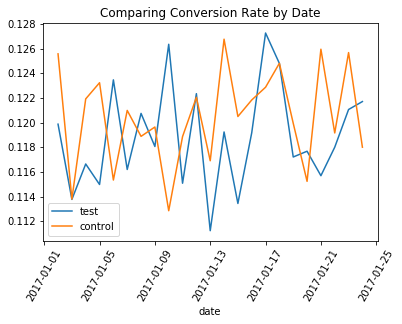

Ttest_indResult(statistic=-1.8123288054674913, pvalue=0.0699579338988825)
Ttest_indResult(statistic=0.05182821974845549, pvalue=0.9586663564605943)
Ttest_indResult(statistic=-0.6795024407954999, pvalue=0.49683133482307695)
Ttest_indResult(statistic=0.33111903181744556, pvalue=0.7405597598504309)
Ttest_indResult(statistic=2.3999515991310387, pvalue=0.01641085244784032)
Ttest_indResult(statistic=-0.4836129647924235, pvalue=0.628668638020595)
Ttest_indResult(statistic=0.7611804663738991, pvalue=0.446562930057432)
Ttest_indResult(statistic=-0.9315635899845935, pvalue=0.3515792521983202)
Ttest_indResult(statistic=-1.261388402374626, pvalue=0.20719113309271808)
Ttest_indResult(statistic=-0.0026642818202597274, pvalue=0.9978742538059032)
Ttest_indResult(statistic=-0.28071255594768935, pvalue=0.7789352633524722)
Ttest_indResult(statistic=-0.2056136446252576, pvalue=0.837095874040602)
Ttest_indResult(statistic=0.4909032980527966, pvalue=0.6235093367111435)
Ttest_indResult(statistic=-0.809492283

In [9]:
# compare conversion rates by date
fig = new_df[new_df.group == 'treatment'][['date','converted']].groupby('date').mean().plot()
new_df[new_df.group == 'control'][['date', 'converted']].groupby('date').mean().plot(ax = fig)
plt.legend(['test', 'control'])
plt.title('Comparing Conversion Rate by Date')
plt.xticks(rotation = 60)
plt.show()

# generating a test statistic to compare test and control on date
for date in new_df.date.unique():
    dated_data = new_df[new_df.date == date]
    print(stats.ttest_ind(dated_data[dated_data.group == 'treatment'].converted,
                         dated_data[dated_data.group == 'control'].converted))


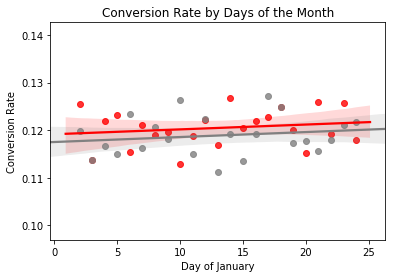

In [10]:
# create day column
new_df['day'] = new_df['timestamp'].dt.day

# mean conversion rate of old and new pages of individual day
cr_by_day = pd.DataFrame()
old_page = new_df.query('landing_page=="old_page"')
new_page = new_df.query('landing_page=="new_page"')
cr_by_day['old_rate']=old_page.groupby('day')['converted'].mean()
cr_by_day['new_rate']=new_page.groupby('day')['converted'].mean()
cr_by_day.reset_index(inplace=True)

# regression plot to see if there is increase in conversion rate as time goes on
_ = sns.regplot(x = 'day', y = 'old_rate', data = cr_by_day, color = 'red')
_ = sns.regplot(x = 'day', y = 'new_rate', data = cr_by_day, color = 'grey')
_.set(xlabel = 'Day of January', ylabel = 'Conversion Rate', title = 'Conversion Rate by Days of the Month')
plt.show()


From the regression plot we can conclude that there is a very slow increase in conversion rate as time goes on. And the regression line for the new landing page is under the regression line of the old page. This could be interpreted as the old page performs better than the new page.

In [29]:
# calculate z-value
convert_old = (new_df.query('landing_page=="old_page"')['converted']==1).sum()
convert_new = (new_df.query('landing_page=="new_page"')['converted']==1).sum()
n_old = (new_df['landing_page']=='old_page').sum()
n_new=(new_df['landing_page']=='new_page').sum()

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='smaller')
print('z-score: {}, p-value: {}'.format(round(z_score, 2), round(p_value, 2)))

z-score: -1.31, p-value: 0.09


In [31]:
# Mann-Whitney U-test
print(stats.mannwhitneyu(new_df[new_df.group == 'treatment'].converted, new_df[new_df.group == 'control'].converted))

MannwhitneyuResult(statistic=10538288235.5, pvalue=0.09482668243543424)


# Conclusion
The critical z-score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. The p-value associated with a 95% confidence level is 0.05. When z-score is between -1.96 and +1.96, the p-value will be larger than 0.05, and we cannot reject your null hypothsis. In our case the z-score is -1.31 and the p-value is 0.09, meaning that the z-score is less than the critical value 1.96. and the p-value is larger than alpha (0.05). Consequently, we fail to reject null-hypothesis. 